In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
recon = np.load('reconstructed_array.npy')
ground = np.load('ground_truth.npy')

### Pick your example to plot

#### This will calculate where the padding starts

In [192]:
example = 10

mask = ground[example][0] != 0
sum_result = np.sum(mask, axis=1)
start_of_padding = sum_result[0]+1

##### Here we are extracting the examples defined above

In [193]:
ground_truth_example = ground[example][0][:start_of_padding,:start_of_padding]
recon_example = recon[example][0][:start_of_padding,:start_of_padding]

# Make the diagonal 0s in reconstructed matrix because we don't calculate loss on these in VAE
np.fill_diagonal(recon_example, 0)

##### Ground truth plot

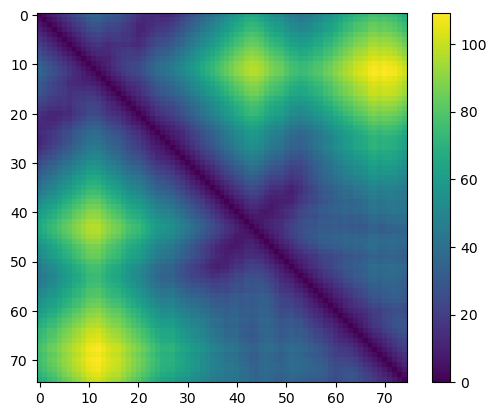

In [194]:
plt.imshow(ground_truth_example)
plt.colorbar()

##### Reconstruction attempt plot

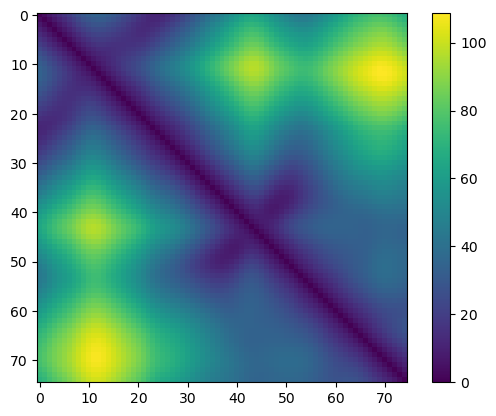

In [196]:
plt.imshow(recon_example)
plt.colorbar()

##### Difference between the two distance maps

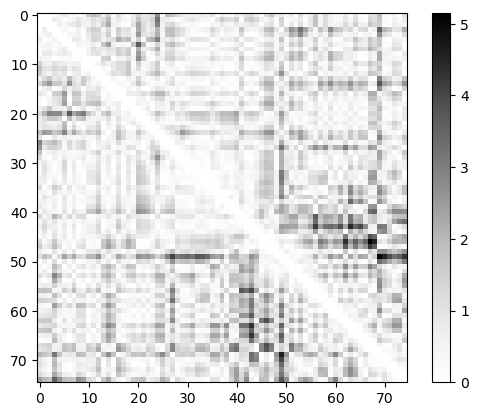

In [195]:
plt.imshow(abs(ground_truth_example - recon_example), cmap='Greys')
plt.colorbar(cmap='bw')

In [199]:
difference = np.abs(ground_truth_example - recon_example)

indices = np.where(difference==difference.max())

print(f'Largest deviation from ground truth {difference.max():.4f}A between bead {indices[0][0]} and {indices[1][0]}')

Largest deviation from ground truth 5.1530A between bead 46 and 67


## Reconstruction error of bond lengths

In [198]:
mean_error = np.mean(np.abs([ground_truth_example[i,i+1] - recon_example[i,i+1] for i in range(start_of_padding-1)]))

print(f'Mean error of bond length reconstruction: {mean_error:.4f}A')

Mean error of bond length reconstruction: 0.0290A


## Are there any beads that are clashing with other beads?

In [197]:
clash_distance = 6.27

clash_mask = np.where(recon_example < clash_distance, 1, 0)

# Remove the diagonal elements
np.fill_diagonal(clash_mask,0)

# Remove off-diagonal elements one position below the main diagonal
np.fill_diagonal(clash_mask[1:], 0)

# Remove off-diagonal elements one position above the main diagonal
np.fill_diagonal(clash_mask[:,1:], 0)

print(f'Number of clashing beads: {clash_mask.sum()/2}')

Number of clashing beads: 0.0


#### Plot where the clash is

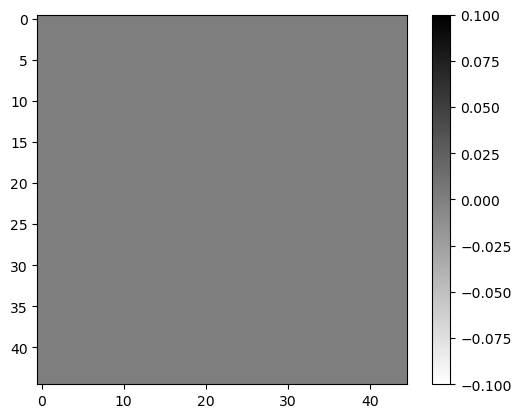

In [188]:
plt.imshow(clash_mask,cmap='binary')
plt.colorbar()

#### What is the distribution of error

In [200]:
start = 3
end = 5
stride = end-start

num_bins = int((ground_truth_example.max()-start)/stride)

mean_errors = []

labels = []


for i in range(num_bins):
    ground_mask = np.where((start < ground_truth_example) & (ground_truth_example < end), 1, 0)
    ground_truth_distances = ground_truth_example * ground_mask
    recon_distances = recon_example * ground_mask
    absolute_difference = abs(ground_truth_distances-recon_distances)
    mean_absolute_difference = absolute_difference.sum()/np.count_nonzero(absolute_difference)
    mean_errors.append(mean_absolute_difference)
    labels.append(end)
    
    start += stride
    end += stride


Text(0, 0.5, 'Error in Angstrom')

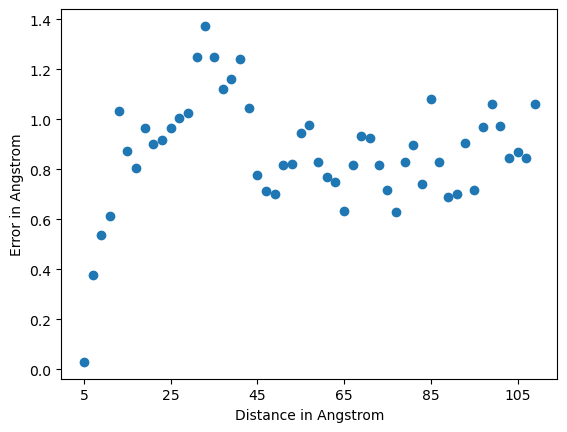

In [201]:
plt.scatter(range(len(mean_errors)),mean_errors)
plt.xticks(range(len(mean_errors))[::10], labels[::10])

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')

Text(0, 0.5, 'Error in Angstrom')

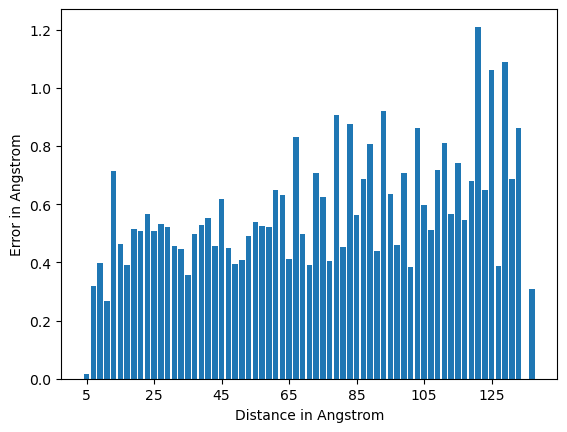

In [191]:
plt.bar(range(len(mean_errors)),mean_errors)
plt.xticks(range(len(mean_errors))[::10], labels[::10])

plt.xlabel('Distance in Angstrom')
plt.ylabel('Error in Angstrom')